In [29]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import pandas as pd
import os
from tqdm import tqdm
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2

In [30]:
dataset, info = tfds.load("food101", with_info=True, as_supervised=True)
train_data, test_data = dataset["train"], dataset["validation"]

In [31]:
class_names = info.features["label"].names
print(f"Total class: {len(class_names)}")
print(class_names[:20])  # Ambil 20 kelas pertama

selected_classes = [
    "apple_pie", "baby_back_ribs", "baklava", "beef_carpaccio", "beef_tartare",
    "breakfast_burrito", "caesar_salad", "cheesecake", "chicken_curry", "churros",
    "donuts", "edamame", "falafel", "french_fries", "frozen_yogurt",
    "grilled_cheese_sandwich", "hamburger", "hot_and_sour_soup", "ice_cream", "lasagna"
]

Total class: 101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla']


In [32]:
def save_subset(dataset, class_names, selected_classes, split_dir="train", limit_per_class=100):
    os.makedirs(f"dataset/{split_dir}", exist_ok=True)
    for class_name in selected_classes:
        os.makedirs(f"dataset/{split_dir}/{class_name}", exist_ok=True)

    counter = {cls: 0 for cls in selected_classes}
    
    for image, label in tqdm(dataset):
        label_name = class_names[label.numpy()]
        if label_name in selected_classes and counter[label_name] < limit_per_class:
            path = f"dataset/{split_dir}/{label_name}/{label_name}_{counter[label_name]}.jpg"
            tf.keras.utils.save_img(path, image)
            counter[label_name] += 1
        if all(c >= limit_per_class for c in counter.values()):
            break

save_subset(train_data, class_names, selected_classes, split_dir="train", limit_per_class=70)
save_subset(test_data, class_names, selected_classes, split_dir="val", limit_per_class=20)
save_subset(test_data, class_names, selected_classes, split_dir="test", limit_per_class=10)

  7%|▋         | 1684/25250 [00:02<00:28, 837.95it/s] 


In [33]:
img_size = (224, 224)
batch_size = 32

train_ds = image_dataset_from_directory(
    "dataset/train",
    label_mode="categorical",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    "dataset/val",
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    "dataset/test",
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

preprocess = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Fine-tuning nanti

model = models.Sequential([
    data_augmentation,
    preprocess,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # bisa disesuaikan
)

test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc*100:.2f}%")

Found 1400 files belonging to 20 classes.
Found 400 files belonging to 20 classes.
Found 200 files belonging to 20 classes.
Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'breakfast_burrito', 'caesar_salad', 'cheesecake', 'chicken_curry', 'churros', 'donuts', 'edamame', 'falafel', 'french_fries', 'frozen_yogurt', 'grilled_cheese_sandwich', 'hamburger', 'hot_and_sour_soup', 'ice_cream', 'lasagna']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 660ms/step - accuracy: 0.1907 - loss: 2.7755 - val_accuracy: 0.5950 - val_loss: 1.4275
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 774ms/step - accuracy: 0.5423 - loss: 1.4765 - val_accuracy: 0.6475 - val_loss: 1.1353
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 675ms/step - accuracy: 0.6255 - loss: 1.2004 - val_accuracy: 0.6750 - val_loss: 1.0786
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 576ms/step - accuracy: 0.7072 - loss: 0.9741 - val_accuracy: 0.6875 - val_loss: 0.9677
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 549ms/step - accuracy: 0.7065 - loss: 0.9515 - val_accuracy: 0.6850 - val_loss: 0.9672
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 560ms/step - accuracy: 0.7521 - loss: 0.7842 - val_accuracy: 0.7175 - val_loss: 0.9330
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 44s 628ms/step - accuracy: 0.7731 - loss: 0.7082 - val_accuracy: 0.6850 - val_loss: 0.9886
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 590ms/step - accuracy: 0.8199 - loss: 0.6072 - val_accu

In [35]:
model.save("model/letthemcook_model.h5")

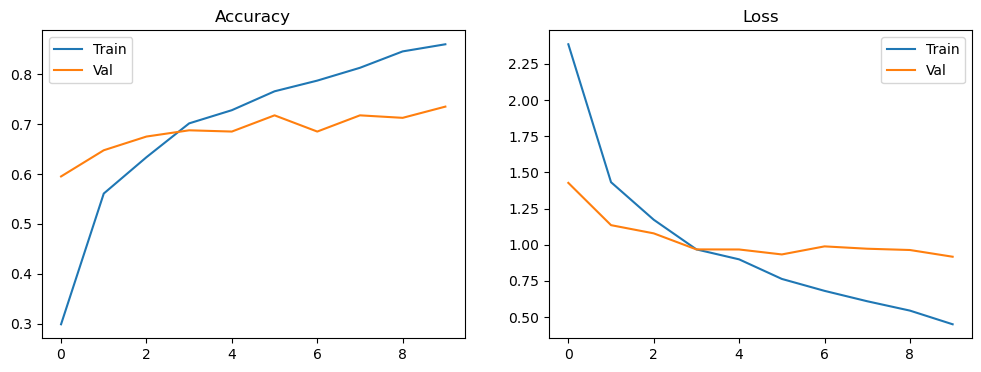

In [36]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.show()
